In [21]:
import yfinance as yf
import pandas as pd

ticker = "^HSI"

data = yf.download(
    ticker,
    start="2000-01-01",
    progress=False
)

data = data.reset_index()

data.to_csv(
    "../data/hsi_daily.csv",
    index=False
)

data.head()


Price,Date,Close,High,Low,Open,Volume
Ticker,,^HSI,^HSI,^HSI,^HSI,^HSI
0,2000-01-03,17369.630859,17426.160156,17057.699219,17057.699219,0
1,2000-01-04,17072.820312,17303.000000,16933.519531,17303.000000,0
2,2000-01-05,15846.719727,16608.550781,15688.490234,16608.550781,0
3,2000-01-06,15153.230469,15971.030273,14763.969727,15942.070312,0
4,2000-01-07,15405.629883,15513.889648,15108.750000,15329.339844,0


In [22]:
import pandas as pd
import numpy as np

In [14]:
data = pd.read_csv("../data/hsi_daily.csv")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date").reset_index(drop=True)

In [23]:
data.head()


Price,Date,Close,High,Low,Open,Volume
Ticker,,^HSI,^HSI,^HSI,^HSI,^HSI
0,2000-01-03,17369.630859,17426.160156,17057.699219,17057.699219,0
1,2000-01-04,17072.820312,17303.000000,16933.519531,17303.000000,0
2,2000-01-05,15846.719727,16608.550781,15688.490234,16608.550781,0
3,2000-01-06,15153.230469,15971.030273,14763.969727,15942.070312,0
4,2000-01-07,15405.629883,15513.889648,15108.750000,15329.339844,0


In [24]:
import matplotlib.pyplot as plt


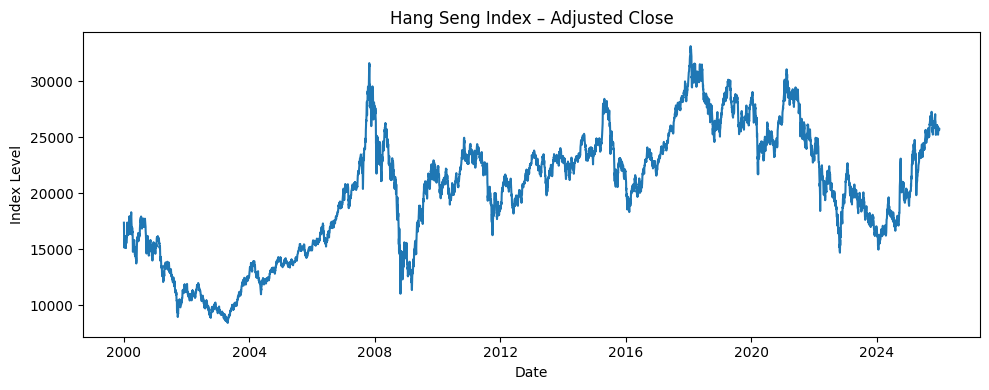

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(data["Date"], data["Close"])
plt.title("Hang Seng Index – Adjusted Close")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.tight_layout()
plt.show()


In [27]:


data["log_return"] = np.log(data["Close"]) - np.log(data["Close"].shift(1))
data = data.dropna()


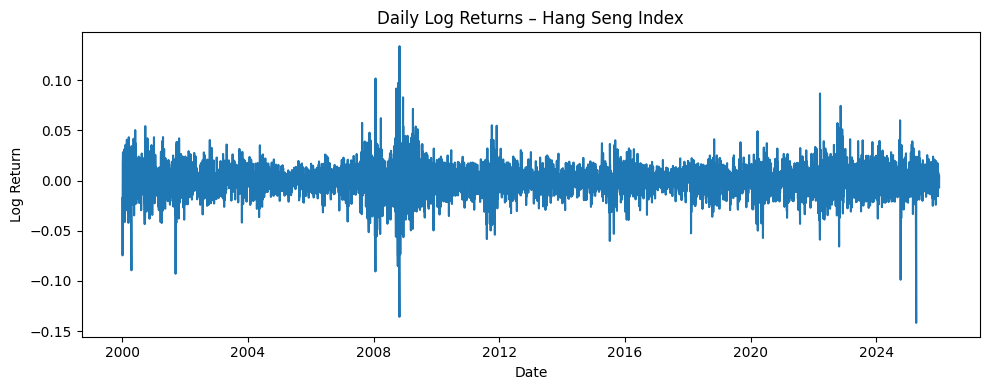

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(data["Date"], data["log_return"])
plt.title("Daily Log Returns – Hang Seng Index")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.tight_layout()
plt.show()


In [29]:
data["rolling_vol_30"] = data["log_return"].rolling(30).std()


C:\Users\Asus\AppData\Local\Temp\ipykernel_11084\2956226782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["rolling_vol_30"] = data["log_return"].rolling(30).std()


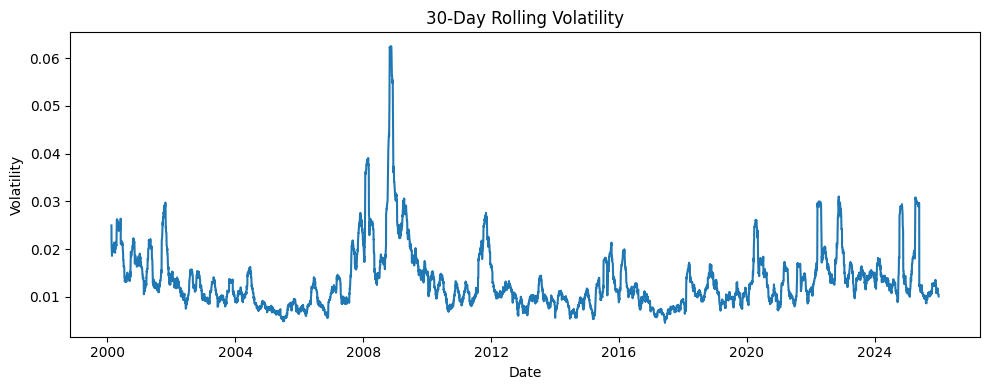

In [30]:
plt.figure(figsize=(10, 4))
plt.plot(data["Date"], data["rolling_vol_30"])
plt.title("30-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.tight_layout()
plt.show()

Initial Observations:

• The price series shows strong non-stationarity with multiple structural breaks.


• Log returns fluctuate around a constant mean with periods of clustered volatility.


• Rolling volatility suggests time-varying variance and possible regime shifts.


Augmented Dickey–Fuller (ADF) test
 
Null hypothesis (H₀):

-The series has a unit root → non-stationary

Alternative (H₁):

-The series is stationary

Interpretation rule (simple):

1. p-value < 0.05 → reject H₀ → stationary

2. p-value ≥ 0.05 → non-stationary

In [32]:
from statsmodels.tsa.stattools import adfuller


In [33]:
returns = data["log_return"].dropna()

adf_result = adfuller(returns)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -26.588339818326148
p-value: 0.0


these formally proves the returns are stationary

Autocorrelation (returns vs volatility)

Returns themselves:

-Almost no autocorrelation

-Past returns don’t predict future returns

Squared returns:

-Strong autocorrelation

-Volatility does have memory

This is the mathematical proof of volatility clustering.

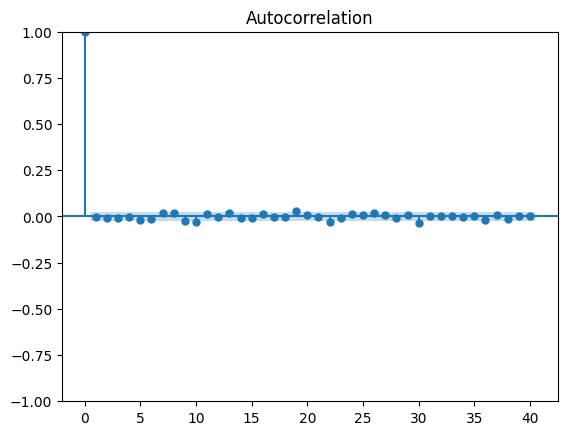

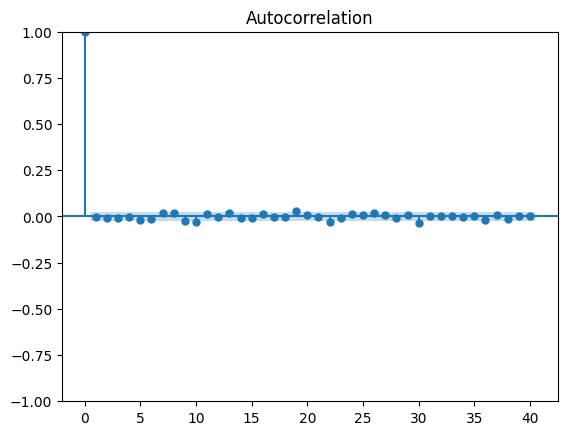

In [34]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(returns, lags=40)


Interpretation: 

1. Bars mostly inside confidence bands

2. No structure

This supports weak-form market efficiency.

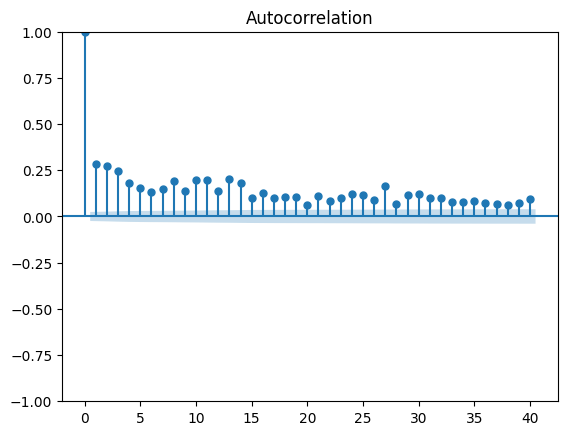

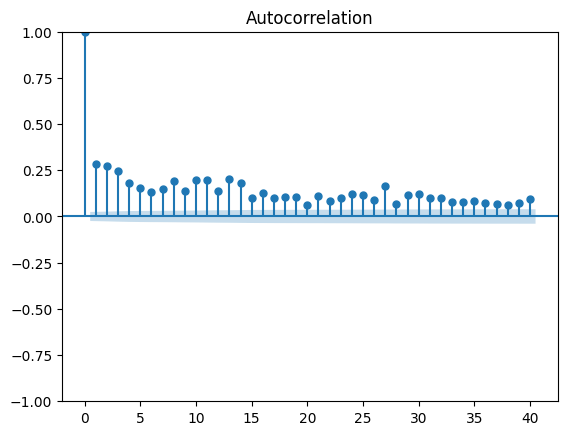

In [35]:
plot_acf(returns**2, lags=40)


Interpretations: 

1. Significant spikes at many lags

2. Slowly decaying pattern

Volatility today depends on volatility yesterday
--This is volatility clustering proven statistically, not visually.

ARCH Effect Test (Engle test):


“Is a volatility model justified here?”

Hypotheses

Null (H₀):
No ARCH effect → constant variance

Alternative (H₁):
ARCH effect present → variance depends on past squared returns

In [36]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(returns)

labels = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
for name, value in zip(labels, arch_test):
    print(f"{name}: {value}")


LM Statistic: 1055.7588732938787
LM p-value: 1.811750449774832e-220
F Statistic: 126.23837567998669
F p-value: 2.393375947807856e-241


The ARCH LM test strongly rejects the null hypothesis of homoskedasticity (p < 0.001), providing robust evidence of time-varying volatility and motivating the use of GARCH-type models.

GARCH(1,1)

GARCH models volatility, not returns.

In [37]:
from arch import arch_model

garch = arch_model(
    returns * 100,
    mean="Zero",
    vol="GARCH",
    p=1,
    q=1
)

garch_result = garch.fit(disp="off")
print(garch_result.summary())


                       Zero Mean - GARCH Model Results                        
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10694.7
Distribution:                  Normal   AIC:                           21395.3
Method:            Maximum Likelihood   BIC:                           21415.6
                                        No. Observations:                 6404
Date:                Tue, Dec 30 2025   Df Residuals:                     6404
Time:                        18:39:56   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0180  5.402e-03      3.337  8.458e-04 [7.

Alpha (α = 0.0636) : The Hang Seng Index reacts to market news, but volatility is not driven purely by daily surprises. [Shock Reaction]

--Moderate reaction to shocks

--News impacts volatility, but does not dominate it

Beta (β = 0.9283) : Once volatility rises in the HSI, it remains elevated for a long time.

--Crises don’t end quickly

--Calm periods persist

Alpha + Beta = volatility memory
α + β = 0.0636 + 0.9283 ≈ 0.992

This implies: 

--Very close to 1

--Extremely strong volatility clustering

--Long memory in variance

The HSI exhibits highly persistent conditional heteroskedasticity.


Volatility half-life

In [38]:
import numpy as np

alpha = garch_result.params["alpha[1]"]
beta = garch_result.params["beta[1]"]

half_life = np.log(0.5) / np.log(alpha + beta)
half_life


84.70482083040781

Half Life --- ≈85 trading days

Interpretation:

After a major volatility shock, it takes about 4 months for risk to reduce by half.

This matches:

Asian financial crisis effects

Global financial crisis

COVID-era aftershocks

Plot conditional volatility

<Axes: title={'center': 'GARCH(1,1) Conditional Volatility'}>

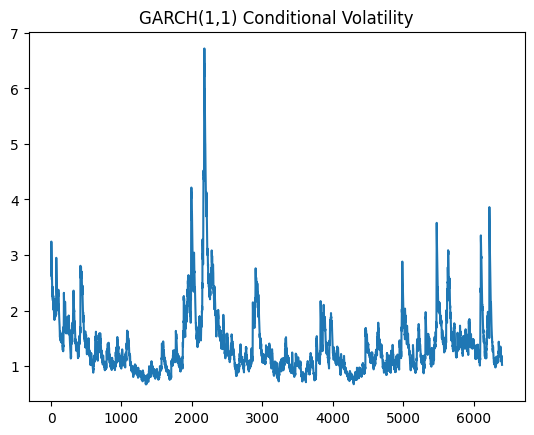

In [39]:
cond_vol = garch_result.conditional_volatility

cond_vol.plot(title="GARCH(1,1) Conditional Volatility")


The estimated GARCH(1,1) model reveals strong volatility clustering in the Hang Seng Index, with high persistence (α + β ≈ 0.99), indicating that volatility shocks decay slowly and risk remains elevated long after major market events.

## Results and Findings

This study analyzed the volatility characteristics of the Hang Seng Index (HSI) using daily data and econometric time-series techniques.

### Price and Return Behavior
The raw price series of the Hang Seng Index exhibits long-term trends and structural movements, making it non-stationary. After transforming prices into log returns, the series becomes stationary with a mean close to zero, which is typical for financial return data.

Visual inspection of the returns shows periods of high volatility followed by periods of low volatility, indicating the presence of volatility clustering — a key stylized fact of financial markets.

### Rolling Volatility Analysis
Rolling window volatility reveals clear clustering behavior. Large shocks to returns tend to be followed by sustained periods of elevated volatility rather than isolated spikes. This visual evidence suggests that volatility is time-varying and conditionally heteroskedastic.

### ARCH Effect Testing
Formal statistical testing using the ARCH-LM test strongly rejects the null hypothesis of homoskedasticity. Both the LM and F-statistics are highly significant (p-values ≈ 0), confirming the presence of ARCH effects in the return series. This provides strong justification for the use of GARCH-type models.

### GARCH(1,1) Model Estimation
A GARCH(1,1) model with zero mean was estimated to capture conditional volatility dynamics. All model parameters are statistically significant:

- The ARCH term (α) indicates that volatility reacts to recent shocks.
- The GARCH term (β) captures persistence in volatility.
- The sum α + β is close to one, implying high volatility persistence and slow decay of shocks.

The estimated conditional volatility series successfully captures major periods of market stress, including prolonged high-volatility regimes, which aligns with known historical events affecting the HSI.

### Interpretation
The results confirm that the Hang Seng Index exhibits strong volatility clustering and persistent conditional variance. Shocks to volatility do not dissipate quickly, indicating long memory in the variance process. The GARCH(1,1) model provides an adequate and interpretable framework for modeling these dynamics.

### Conclusion
Overall, the empirical evidence strongly supports the presence of conditional heteroskedasticity in HSI returns. The fitted GARCH(1,1) model effectively captures volatility clustering and persistence, making it suitable for risk analysis and further extensions such as volatility forecasting or Value-at-Risk estimation.
